In [6]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
pd.options.plotting.backend = "plotly"

import scipy.fftpack
from scipy.signal import butter, filtfilt, medfilt
from scipy.ndimage import uniform_filter1d
from scipy import signal
from scipy.signal import find_peaks
from scipy import interpolate
from scipy.signal.signaltools import detrend

### Datasets

In [7]:
# save data in dictionaries for easy looping
signal_data = {}
event_data = {}
flip={}

# Reading 1 
signal_data["M1"] = pd.read_csv('Data/m1.csv')
event_data["M1"] = [1623568142869, 1623568443999, 1623568623752]
flip["M1"] = False

# Reading 2
signal_data["A1"] = pd.read_csv('Data/a1.csv')
event_data["A1"] = [1623587249559, 1623587553231, 1623587733163]
flip["A1"]= True

# Reading 3 
signal_data["A2"] = pd.read_csv('Data/a2.csv')
event_data["A2"] = [1623571666140, 1623571966485, 1623572147235]
flip["A2"]= False

# Reading 4
signal_data["A3"] = pd.read_csv('Data/age52June242021.csv')
event_data["A3"] = [1624509304574, 1624509618657, 1624509783431]
flip["A3"]= False

# Reading 5
signal_data["T1"] = pd.read_csv('Data/age55June242021.csv')
event_data["T1"] = [1624510578929, 1624510877105, 1624511059168]
flip["T1"]= False

# Reading 6
signal_data["M2"] = pd.read_csv('Data/age23June262021.csv')
event_data["M2"] = [1624723469219, 1624723768744, 1624723768923]
flip["M2"]= True

# Reading 7
signal_data["A4"] = pd.read_csv('Data/age52June272021.csv')
event_data["A4"] = [1624803269155, 1624803569284, 1624803749742]
flip["A4"]= True

# Reading 8
signal_data["N1"] = pd.read_csv('Data/age20June272021.csv')
event_data["N1"]  = [1624810203138, 1624810504150, 1624810697546]
flip["N1"]= True

# Reading 9
signal_data["M3"] = pd.read_csv('Data/age23June272021.csv')
event_data["M3"] = [1624812157099, 1624812463834, 1624812648001]
flip["M3"]= True

# Reading 10
signal_data["M4"] = pd.read_csv('Data/age23June292021withCold.csv')
event_data["M4"] = [1624975875204, 1624976180767, 1624976356073]
flip["M4"]= True

# Reading 11
signal_data["A5"] = pd.read_csv('Data/age52June292021.csv')
event_data["A5"] = [1624981671112, 1624981982342 , 1624982157453]
flip["A5"]= True

# Reading 12
signal_data["N2"] = pd.read_csv('Data/age20June292021.csv')
event_data["N2"] = [1624983536426, 1624983837325, 1624984023832]
flip["N2"]= True

# Reading 13
signal_data["T2"] = pd.read_csv('Data/age55July032021.csv')
event_data["T2"] = [1625282721122, 1625283023666, 1625283203210]
flip["T2"]= True

# Reading 12
signal_data["N3"] = pd.read_csv('Data/age20July032021.csv')
event_data["N3"] = [1625285355125, 1625285667437, 1625285836317]
flip["N3"]= True

In [8]:
S_fs = 100
P_fs = 100
T_fs = 10
I_fs = 20

def get_timePoints(data:pd.Series,timestamps:[int])->[int]:
    deviation = 100
    location = []
    for time in timestamps:
        try:
            match = data[(data>time-deviation)&(data<time+deviation)].index[0]
            location.append(match)
        except:
            print(f'Timestamp {time} not found in data')
    return location

In [9]:
def clean_data(data, max_val=2*64, min_val=-2*64):
    # Accepts a numpy array, remove nan and return values in range. Replace outliers with mean
    data_without_nan = data[~np.isnan(data)] #  FOR DF   data_without_nan = data.dropna()
    mean_val = np.mean(data_without_nan)
    data_without_nan[data_without_nan > max_val] = mean_val
    data_without_nan[data_without_nan < min_val] = mean_val
    return data_without_nan

def replace_nan(data, replace_with):
    data[np.isnan(data)] = replace_with
    return data

In [21]:
def plot(data,timestamps):
    fig = go.Figure(data=go.Scatter(x=timestamps,y=data))
    fig.show()

In [10]:
def filter_ppg(raw_signal, fs, to_plot):
    # Clean the signal - Mean removal
    raw_signal = raw_signal - np.mean(raw_signal)

    # Lowpass filtering
    A_low = 100
    delt_w_low = 7.21 - 3.8
    M_low = (A_low-8)/(2.285*delt_w_low)
    order_low = 80
    fc_low = 6

    b_low = signal.firwin(order_low, fc_low, window=('kaiser', M_low), fs=fs) 
    filtered_low = filtfilt(b_low, 1, raw_signal)

    # Highpass filtering
    fc_high = 0.5
    order_high = 201

    b_high = signal.firwin(order_high, fc_high, window='hamming', pass_zero=False, fs=fs)       # WHY????
    filtered_bp = filtfilt(b_high, 1, filtered_low)

    return filtered_bp

In [29]:
def rescale(sig, base):
    FACTOR = 1.4
    pk, _ = find_peaks(base, distance=60, prominence=(None, 0.6))
    if len(pk):
        thresh = np.mean(base[pk])*FACTOR
    else:
        pk, _ = find_peaks(base, distance=60)
        thresh = np.mean(base[pk])*FACTOR
    
    sig = sig[np.where(~(sig>thresh))] # @TODO
    sig = sig[np.where(~(sig<-thresh))]

    # clean_sig = remove_nan(sig)
    clean_sig = sig/thresh # get to same scale
    return sig

In [40]:
def get_filt_ppg(data, flip, time_stamps):

    if flip:
        SData = data.SCData
        BData = data.BCData
        SCData = data.SData
        BCData = data.BData
        Stime = data.SCDatatime 
    else:
        SData = data.SData
        BData = data.BData
        SCData = data.SCData
        BCData = data.BCData
        Stime = data.SDatatime 
        
    time_points = get_timePoints(Stime, time_stamps)

    red = clean_data(BData, 33000,0)
    ir = clean_data(SData, 33000,0)
    R = (red/np.mean(red))/(ir/np.mean(ir))
    SPO2 = 110 - 25*R

    redC = clean_data(BCData, 33000,0)
    irC = clean_data(SCData, 33000,0)
    RC = (redC/np.mean(redC))/(irC/np.mean(irC))
    SPO2C = 110 - 25*RC

#     plot_ppg_raw(SPO2, SPO2C, time_points)

    filtered_ppg_signal = filter_ppg(SPO2, S_fs, True)
    clean_filtered = clean_data(filtered_ppg_signal, 32000,-32000)
#     baseline = filtered_ppg_signal[time_points[0]:time_points[1]]
#     filtered_ppg = rescale(filtered_ppg_signal, baseline)

    filtered_ppgC_signal = filter_ppg(SPO2C, S_fs, True)
    clean_filteredC = clean_data(filtered_ppgC_signal, 32000,-32000)
#     baselineC = filtered_ppgC_signal[time_points[0]:time_points[1]]
#     filtered_ppgC = rescale(filtered_ppgC_signal, baselineC)

    return [time_points, clean_filtered, clean_filteredC]

In [19]:
def get_pulse_amps(data):
    peaks, _ = find_peaks(data, distance=60)
    return peaks

def norm(preOcclusion, preOcclusionC, postOcclusion, postOcclusionC):
    pre_amps = get_pulse_amps(preOcclusion)
    post_amps = get_pulse_amps(postOcclusion)
    pre_ampsC = get_pulse_amps(preOcclusionC)
    post_ampsC = get_pulse_amps(postOcclusionC)

    # @TODO check alignment of peaks
    pre_x = np.linspace(max(pre_amps[0],pre_ampsC[0]), min(pre_amps[-1],pre_ampsC[-1]), round(max(pre_amps[-1],pre_ampsC[-1])/10))
    post_x = np.linspace(max(post_amps[1],post_ampsC[1]), min(post_amps[-1],post_ampsC[-1]), round(max(post_amps[-1],post_ampsC[-1])/10))

    pre_f = interpolate.interp1d(pre_amps, preOcclusion[pre_amps])
    preC_f = interpolate.interp1d(pre_ampsC, preOcclusionC[pre_ampsC])
    post_f = interpolate.interp1d(post_amps, postOcclusion[post_amps])
    postC_f = interpolate.interp1d(post_ampsC, postOcclusionC[post_ampsC])

    preSig = pre_f(pre_x)
    preSigC = preC_f(pre_x)
    postSig = post_f(post_x)
    postSigC = postC_f(post_x)

    pre_norm = (preSig/preSigC)
    post_norm = (postSig/postSigC)
    
    return [pre_norm, post_norm]

def get_hyp_indices(post_norm, fs): #IGNORE
    # Indices: hyp_pk, hyp_loc, hyp_grad, hyp_AUC
    filtered_hyp = uniform_filter1d(post_norm, size=50)
    hyp_pk = max(filtered_hyp[:int(len(filtered_hyp)/2)])
    hyp_loc = np.argmax(filtered_hyp[:int(len(filtered_hyp)/2)])/fs
    hyp_grad = hyp_pk/hyp_loc
    filtered_hyp[filtered_hyp<0]=0
    hyp_AUC = np.trapz(filtered_hyp,dx=1/fs)

    return [hyp_pk, hyp_loc, hyp_grad, hyp_AUC]

In [79]:
def indices_fft(sig, fs, name):
    # Indices: PF, PPGi,PPGVLFi
    print(fs,sig)
    period = 1/fs
    nSamples = len(sig)   
    
    yf = scipy.fftpack.fft(sig)
    xf = np.linspace(0.0, 1.0/(2.0*period), nSamples//2) 
    Yf = np.abs(yf[0:nSamples//2])

    peaks, _ = find_peaks(Yf[500:], distance=1000) #ignore DC peak @TODO check if correct peaks
    PF = xf[500:][peaks[:3]]
    Af = Yf[500:][peaks[:3]]
    PPGi = np.sum(Af)/Af[0]
    PPGVLFi = PF/PPGi

    return [*PF, *Af, PPGi, *PPGVLFi]

In [68]:
def get_pulses(data):
    # @TODO IMPORTANT check how pulse extraction works
    neg_peaks, _ = find_peaks(-data, distance=60)
    avg_pulse_len = np.mean(np.diff(neg_peaks)) 

    pulses = []
    for i in range(len(neg_peaks)-1):
        pulse = np.zeros(int(avg_pulse_len*1.2))
        p_len = neg_peaks[i+1]-neg_peaks[i]
        
        if (p_len<avg_pulse_len*1.2)&(p_len>avg_pulse_len*0.8):
            p = data[neg_peaks[i]:neg_peaks[i+1]]
            pulse[:p_len] = p - min(p)
            pulses.append(pulse)
            # plt.plot(pulse)
    # plt.show()
    return pulses

def get_pk_locs(pulse):
    sys_pk_loc = np.argmax(pulse)  
    sys_wave = np.zeros(len(pulse))
    sys_wave_half = pulse[:sys_pk_loc]
    reflected_wave = np.concatenate([sys_wave_half,np.flip(sys_wave_half)])
    sys_wave[:min(sys_pk_loc*2,len(pulse))] = reflected_wave[:len(pulse)]
    di_wave = pulse - sys_wave

    di_pk_loc = np.argmax(di_wave)  

    # plt.plot(pulse)
    # plt.plot(sys_wave)
    # plt.plot(di_wave)
    # plt.title('Systolic Wave and Diastolic Wave')
    # plt.legend(['Pulse','Systolic Wave','Diastolic Wave'])
    # plt.xlabel('Sample Points')
    # plt.ylabel('Amplitude')
    # plt.show()
    IPA = np.trapz(di_wave)/np.trapz(sys_wave)

    return [di_pk_loc, sys_pk_loc, IPA]

def pulse_indices(pulse, height):
    # Indices: sys_pk, AUC, delt_T, CT, RI, SI, STT, IPA, pulse_wa_ratio
    [di_pk_loc, CT, IPA] = get_pk_locs(pulse)
    sys_pk = max(pulse)
    di_pk = pulse[di_pk_loc]

    #INDICES @CHECK
    RI = di_pk/sys_pk
    delt_T = di_pk_loc - CT
    SI = height/delt_T
    STT = CT/sys_pk
    pulse_wa_ratio = len(pulse)/sys_pk
    AUC = np.trapz(pulse)

    return [sys_pk, AUC, delt_T, CT, RI, SI, STT, IPA, pulse_wa_ratio]

def get_seg_indices(region, height, WINDOW_LEN = 10):
    # POST_SEG_LEN = len(region)/S_fs
    POST_SEG_LEN = 5*60 #@TODO check for 3 min / make global
    indices = []
    SHIFT_RATIO = WINDOW_LEN #50% thingy
    for i in range(int(POST_SEG_LEN- WINDOW_LEN)):
        seg_start = int(S_fs*i*WINDOW_LEN/SHIFT_RATIO) #convert to len from time
        post_seg = region[seg_start:seg_start+WINDOW_LEN*S_fs]
        seg_pulses = []
        try:
            seg_pulses = get_pulses(post_seg)
            avg_pulse = np.mean(seg_pulses, axis=0)
            seg_indices = pulse_indices(avg_pulse,height)
#             plot(avg_pulse,)
        except Exception as inst:
            print(inst)
            print('Error in segment ',i)
            print(seg_pulses)
            seg_indices = np.zeros(9)
            break
        indices.append(seg_indices)
    
    return indices

def get_pulse_inds(preOcclusion, preOcclusionC, postOcclusion, postOcclusionC):
    index_names = ['sys_pk', 'AUC', 'delt_T', 'CT', 'RI', 'SI', 'STT', 'IPA', 'pulse_wa_ratio']
    height = 165
    # Pre-occlusion
    pre_inds = get_seg_indices(preOcclusion,height, WINDOW_LEN = 10)
    # avg_post_inds = [float(sum(col))/sum(map(bool,col)) if sum(map(bool,col))>0 else 0 for col in zip(*post_inds)]

    pre_indsC = get_seg_indices(preOcclusionC,height, WINDOW_LEN = 10)
    # avg_post_indsC = [float(sum(col))/sum(map(bool,col)) if sum(map(bool,col))>0 else 0 for col in zip(*post_indsC)]

    # Post-occlusion
    post_inds = get_seg_indices(postOcclusion,height, WINDOW_LEN = 10)
    # avg_post_inds = [float(sum(col))/sum(map(bool,col)) if sum(map(bool,col))>0 else 0 for col in zip(*post_inds)]

    post_indsC = get_seg_indices(postOcclusionC,height, WINDOW_LEN = 10)
    # avg_post_indsC = [float(sum(col))/sum(map(bool,col)) if sum(map(bool,col))>0 else 0 for col in zip(*post_indsC)]

    pre_inds = np.array(pre_inds)
    pre_indsC = np.array(pre_indsC)
    post_inds = np.array(post_inds)
    post_indsC = np.array(post_indsC)

    
    return [pre_inds, pre_indsC, post_inds, post_indsC]


In [71]:
def get_ppg_indices(sig, flip, time_stamps):
    
    [time_points, filtered_ppg, filteredC_ppg] = get_filt_ppg(sig, flip, time_stamps)

    PRE_SEG_LEN = 5*60
    POST_SEG_LEN = 5*60 # @ TODO check for 3 minutes

    preOcclusion = filtered_ppg[time_points[1]-PRE_SEG_LEN*S_fs:time_points[1]]
    postOcclusion = filtered_ppg[time_points[2]:time_points[2]+POST_SEG_LEN*S_fs]
    preOcclusionC = filteredC_ppg[time_points[1]-PRE_SEG_LEN*S_fs:time_points[1]]
    postOcclusionC = filteredC_ppg[time_points[2]:time_points[2]+POST_SEG_LEN*S_fs]

    # Hyp indices
#     [ _ , post_norm] = norm(preOcclusion, preOcclusionC, postOcclusion, postOcclusionC)
#     hyp_indices = get_hyp_indices(post_norm, S_fs)
#     indices = hyp_indices
    indices = []
    
    print(filteredC_ppg)
    # Freq indices 
    freq_inds = indices_fft(filteredC_ppg, S_fs, 'SPO2')
    indices.append(freq_inds) # @ TODO check for variation

    # Pulse Indices
    pulse_inds = get_pulse_inds(preOcclusion, preOcclusionC, postOcclusion, postOcclusionC)
    # for i in range(9):
    #     plot_inds_comparison(i, pulse_inds)
    return freq_inds

In [51]:
# EXAMPLE
subject = "N2"
TMP_indicesN = get_ppg_indices(signal_data[subject], True, event_data[subject])

[-0.59786447 -1.34990806 -2.10333199 ...  1.1128042   1.10959887
  1.08060578]
100 [-0.59786447 -1.34990806 -2.10333199 ...  1.1128042   1.10959887
  1.08060578]


# Results

In [80]:
PPG_indices ={}
for subject in signal_data.keys():
    PPG_indices[subject] = get_ppg_indices(signal_data[subject], flip[subject], event_data[subject])
    print(f'{subject} processed')

[-0.01246841 -0.0197315  -0.02738743 ... -0.07989181 -0.09194548
 -0.10343608]
100 [-0.01246841 -0.0197315  -0.02738743 ... -0.07989181 -0.09194548
 -0.10343608]


<ipython-input-68-3ba14a16bb84>:50: RuntimeWarning:

divide by zero encountered in longlong_scalars



M1 processed
[-0.05582833 -0.10674532 -0.15516411 ... -0.07313573 -0.09280178
 -0.11325344]
100 [-0.05582833 -0.10674532 -0.15516411 ... -0.07313573 -0.09280178
 -0.11325344]
A1 processed
[-0.01021645 -0.00790864 -0.00644165 ...  0.0646834   0.05747179
  0.05092452]
100 [-0.01021645 -0.00790864 -0.00644165 ...  0.0646834   0.05747179
  0.05092452]
object of type 'numpy.float64' has no len()
Error in segment  0
[]
object of type 'numpy.float64' has no len()
Error in segment  0
[]


C:\Users\CPN\anaconda3\envs\aienv\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning:

Mean of empty slice.

C:\Users\CPN\anaconda3\envs\aienv\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars



A2 processed
[-0.02372841  0.00782923  0.03959039 ...  0.03944428  0.02958983
  0.01941747]
100 [-0.02372841  0.00782923  0.03959039 ...  0.03944428  0.02958983
  0.01941747]
A3 processed
[-0.06121288 -0.07533443 -0.08964446 ...  0.38024202  0.41483616
  0.43856641]
100 [-0.06121288 -0.07533443 -0.08964446 ...  0.38024202  0.41483616
  0.43856641]
T1 processed
[ 0.0166936   0.04074901  0.06580033 ... -0.0737194  -0.07882473
 -0.08439313]
100 [ 0.0166936   0.04074901  0.06580033 ... -0.0737194  -0.07882473
 -0.08439313]
M2 processed
[-0.06154911 -0.0586564  -0.05602592 ...  0.11922285  0.1124626
  0.10401688]
100 [-0.06154911 -0.0586564  -0.05602592 ...  0.11922285  0.1124626
  0.10401688]
A4 processed
[-0.02547861 -0.09959798 -0.17349147 ...  0.06688982  0.04690123
  0.01806694]
100 [-0.02547861 -0.09959798 -0.17349147 ...  0.06688982  0.04690123
  0.01806694]
object of type 'numpy.float64' has no len()
Error in segment  280
[]
object of type 'numpy.float64' has no len()
Error in segme

C:\Users\CPN\anaconda3\envs\aienv\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning:

Mean of empty slice.

C:\Users\CPN\anaconda3\envs\aienv\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning:

invalid value encountered in double_scalars



In [81]:
indices_df = pd.DataFrame.from_dict(PPG_indices).transpose()
# indices_df.columns= ["TMP_rise", "TMP_fall", 'TMP_rise/fall', "TMP_min", "TMP_base", "TMP_max","TMP_AUC"  ]
indices_df

,0,1,2,3,4,5,6,7,8,9
M1,1.335470,2.646553,3.877508,1623.610637,939.337938,295.636680,1.760635,0.758516,1.503181,2.202336
A1,1.275889,2.564561,3.896702,3146.063869,1447.792051,391.913071,1.584764,0.805097,1.618261,2.458853
A2,1.280675,2.632499,3.885713,27227.050775,25954.065981,22649.379379,2.785116,0.459828,0.945203,1.395171
A3,1.217850,2.521185,3.794787,5688.445255,5089.153227,4336.385570,2.656962,0.458362,0.948898,1.428243
T1,1.221122,2.500635,3.786494,2994.925861,718.165926,217.166191,1.312306,0.930517,1.905528,2.885375
M2,1.443007,2.669152,4.028930,1209.200187,430.712671,165.884786,1.493382,0.966268,1.787320,2.697857
A4,1.202474,2.482567,3.760116,11818.141136,10791.574936,9586.282321,2.724286,0.441390,0.911273,1.380221
N1,1.453775,2.959294,4.403213,8296.011004,3962.271238,908.979542,1.587180,0.915948,1.864498,2.774237
M3,1.413378,2.780469,4.031303,3429.680765,1543.160842,514.467157,1.599947,0.883390,1.737850,2.519647
M4,1.401199,2.960743,4.099030,2227.686834,878.721638,304.510738,1.531148,0.915129,1.933674,2.677095


In [82]:
def plot_df(df,labels):
    df["color"] = labels
    for i in df.columns[:-1]:
        fig = px.scatter(df, x=df.index, y=i, color="color")
        fig.show()

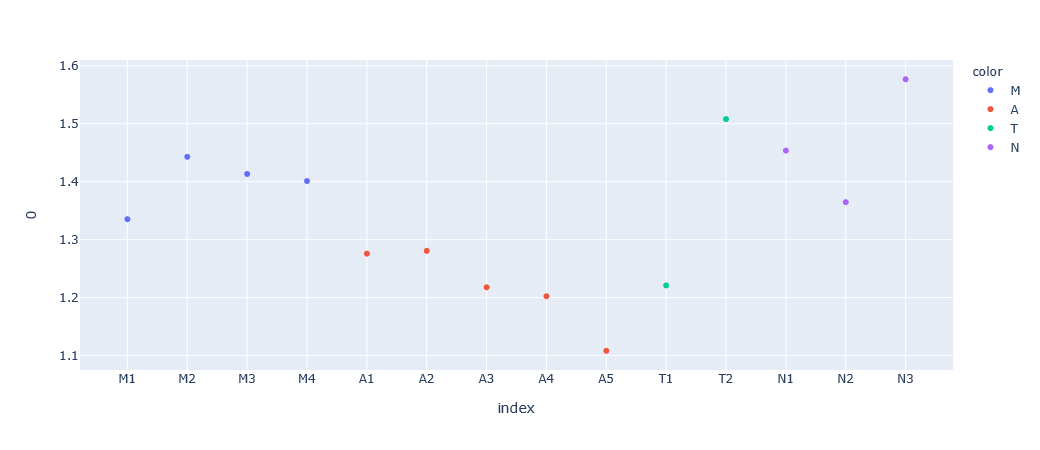

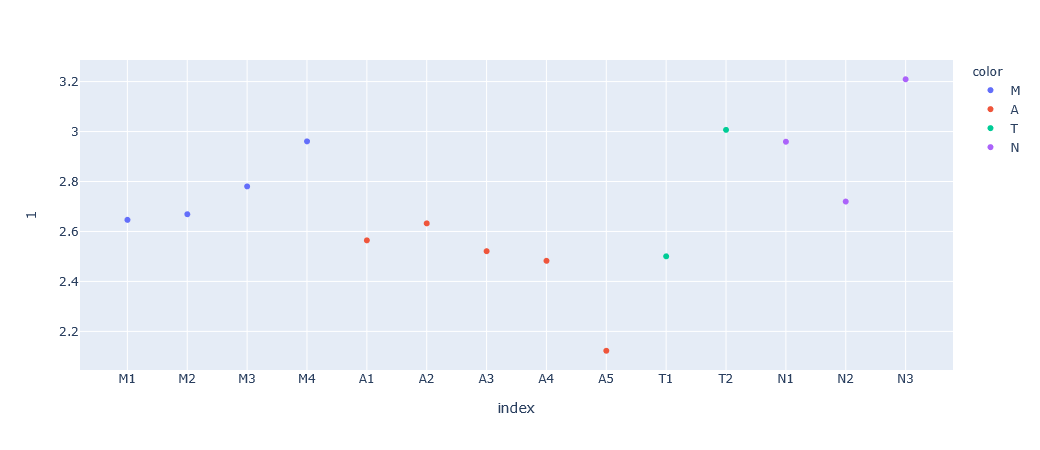

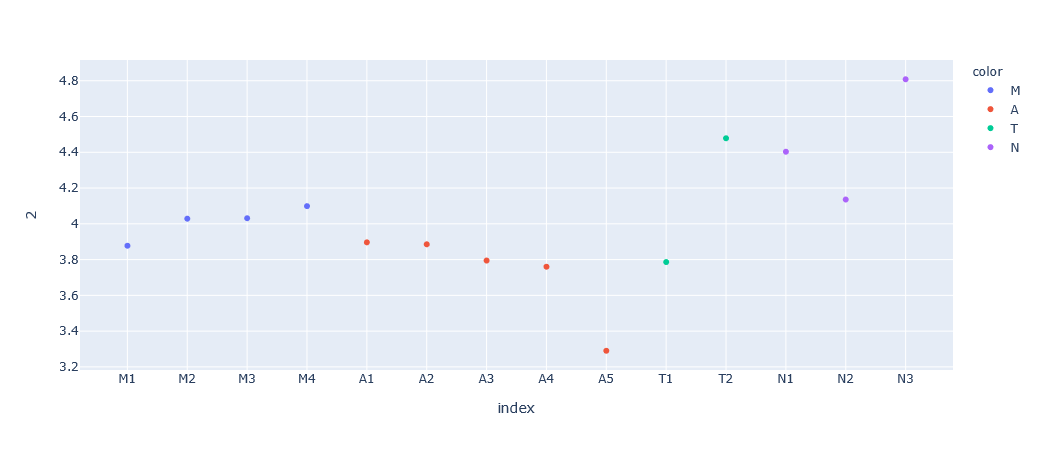

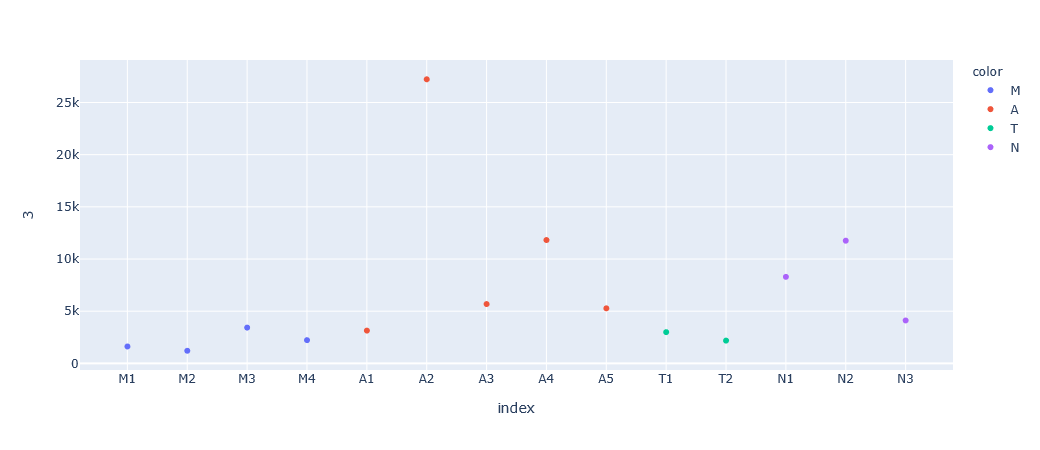

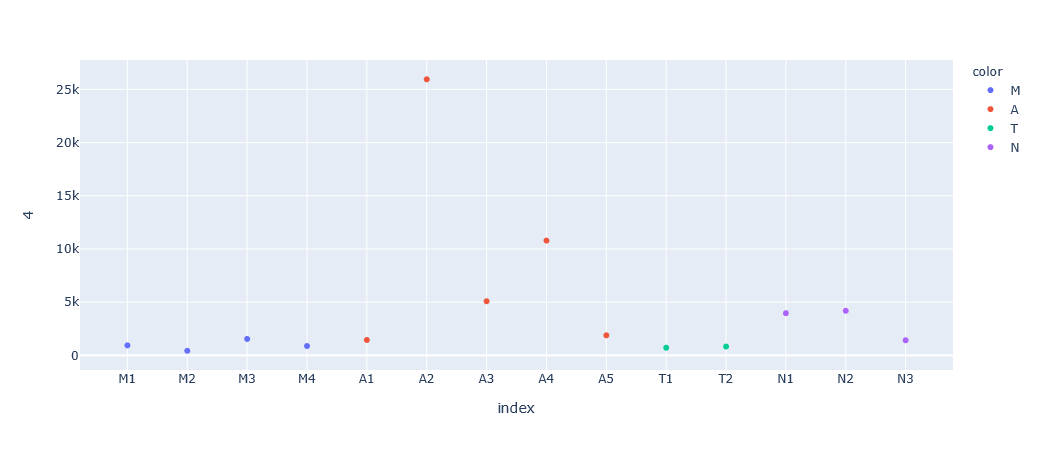

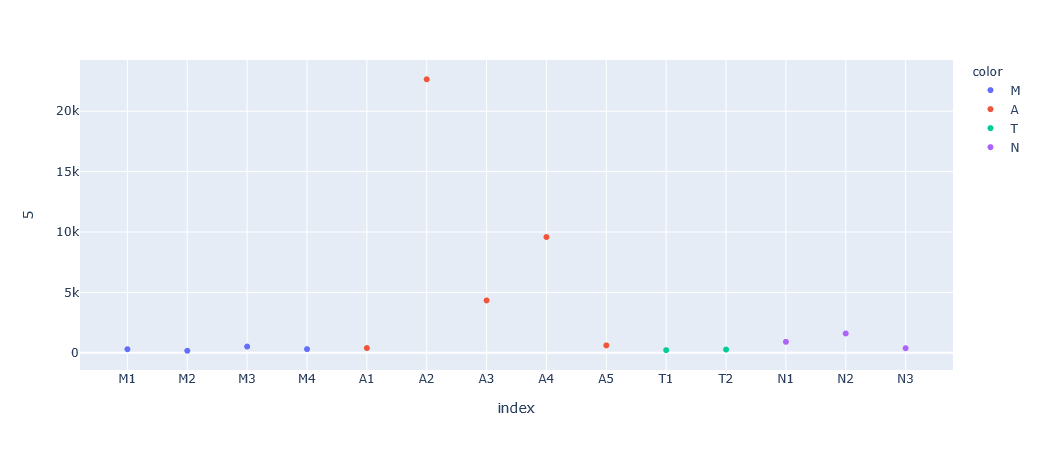

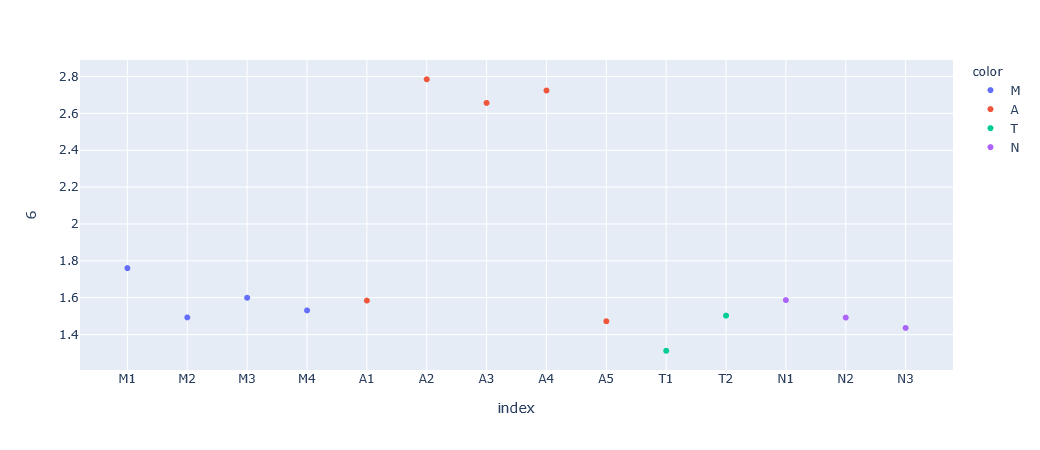

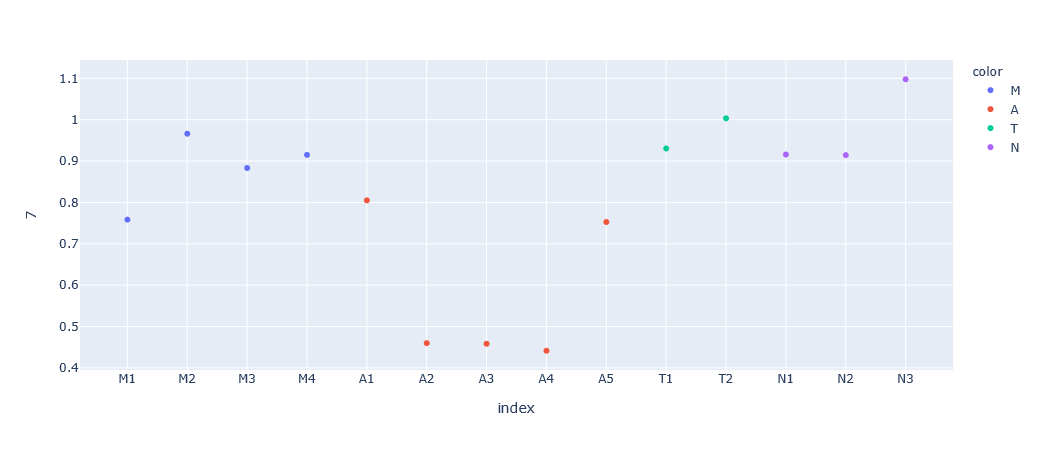

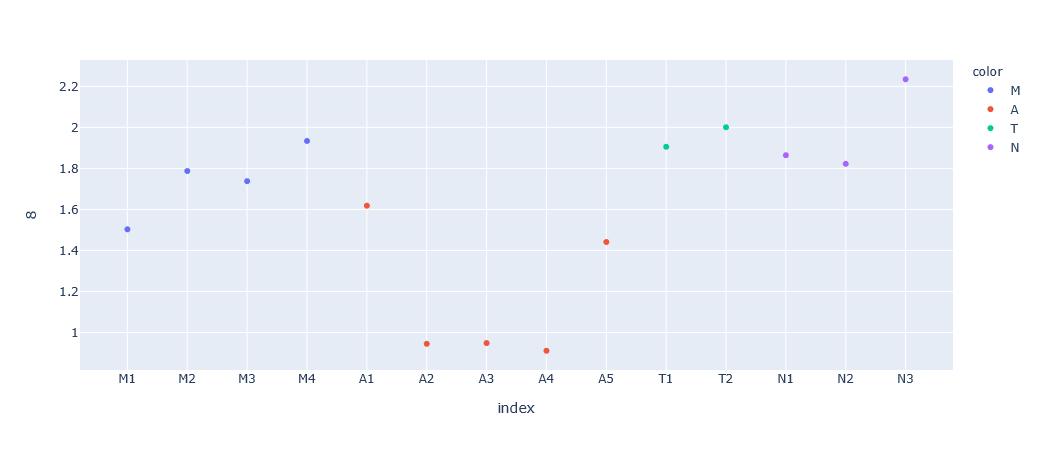

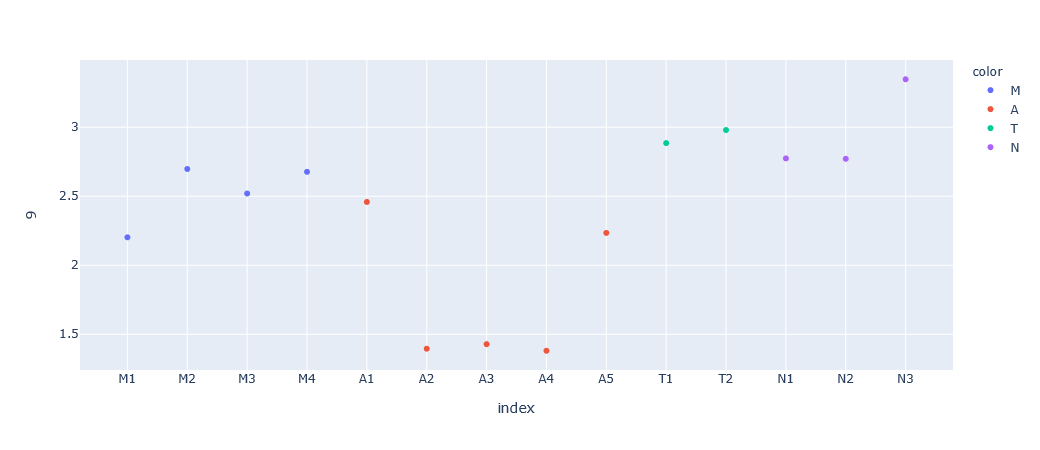

In [83]:
labels = [x[0] for x in signal_data.keys()]
plot_df(indices_df, labels)